In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import joblib

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [165]:
import seaborn as sns

In [172]:
import math

In [3]:
## WebUse behavior Generation  

In [196]:
# read synth household population 
df_hh = pd.read_csv('../Sim_inputs/plans-base-2010/households.csv', header=0, sep=',')

In [198]:
# select variables required for the model
df_hh= df_hh[['household_id', 'persons','tenure', 'workers', 'income', 'cars','race_of_head']]
df_hh.columns = ['household_id','HHSIZE','HOMEOWN', 'WRKCOUNT', 'income_est','HHVEHCNT','HH_RACE']

In [199]:
def race_class(HH_RACE):
    if HH_RACE == 1: 
        return 1 # white
    elif HH_RACE == 2:
        return 2 # black
    elif HH_RACE == 3:
        return 3 # Asian
    else:
        return 4 # others
df_hh['HH_RACE']=df_hh['HH_RACE'].apply(race_class) 

In [200]:
df_hh['WRKCOUNT']=df_hh['WRKCOUNT'].astype(np.int64)
df_hh['income_est']=df_hh['income_est'].astype(np.int64)
df_hh['HHVEHCNT']=df_hh['HHVEHCNT'].astype(np.int64)

In [201]:
df_hh['income_est']=df_hh['income_est']/1000

In [202]:
cat_vars=['HH_RACE']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_hh[var], prefix=var)
    df_hh=df_hh.join(cat_list)

cat_vars=['HH_RACE']
data_vars=df_hh.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
df_hh=df_hh[to_keep]
df_hh.columns.values

array(['household_id', 'HHSIZE', 'HOMEOWN', 'WRKCOUNT', 'income_est',
       'HHVEHCNT', 'HH_RACE_1', 'HH_RACE_2', 'HH_RACE_3', 'HH_RACE_4'],
      dtype=object)

In [203]:
sim_X=df_hh[['HOMEOWN', 'WRKCOUNT', 'income_est','HHVEHCNT', 'HH_RACE_1']]


In [204]:
filename= 'webuse_model.sav'
loaded_model = joblib.load(filename)

In [205]:
sim_Y_web = loaded_model.predict(sim_X)

In [206]:
df_hh['web_use']=loaded_model.predict(sim_X)

In [207]:
df_hh['web_use'].value_counts()

1    1823860
0     579820
2     204343
Name: web_use, dtype: int64

In [ ]:
#### End WebUse behavior generation   

In [208]:
#### Online shopping behavior generation 

In [209]:
df_ps = pd.read_csv('../Sim_inputs/plans-base-2010/persons.csv', header=0, sep=',')

In [210]:
df_ps.columns

Index(['person_id', 'age', 'earning', 'edu', 'hours', 'household_id',
       'member_id', 'race_id', 'relate', 'sex', 'student', 'work_at_home',
       'worker'],
      dtype='object')

In [211]:
# select variables required for the model
df_ps=df_ps[['person_id', 'age', 'earning', 'edu', 'household_id',
        'race_id', 'sex']]

In [212]:
df_ps.columns = ['person_id', 'R_AGE_IMP', 'earning', 'EDUC', 'household_id',
        'R_RACE', 'R_SEX_IMP']

In [213]:
df_ps=df_ps.merge(df_hh, on='household_id', how='left')

In [214]:
df_ps=df_ps.query('R_AGE_IMP >= 16')

In [215]:
list(df_ps.columns)

['person_id',
 'R_AGE_IMP',
 'earning',
 'EDUC',
 'household_id',
 'R_RACE',
 'R_SEX_IMP',
 'HHSIZE',
 'HOMEOWN',
 'WRKCOUNT',
 'income_est',
 'HHVEHCNT',
 'HH_RACE_1',
 'HH_RACE_2',
 'HH_RACE_3',
 'HH_RACE_4',
 'web_use']

In [216]:
df_ps = df_ps.rename(columns={'web_use':'WEBUSE17'})

In [217]:
df_ps['income_est']=df_ps['income_est']/1000

In [218]:
def age_est(R_AGE_IMP):
    if R_AGE_IMP  >=16 and R_AGE_IMP  <25 :
        return 0
    elif R_AGE_IMP  >=25 and R_AGE_IMP  <45:
        return 1
    elif R_AGE_IMP  >=45 and R_AGE_IMP  <65:
        return 2
    elif R_AGE_IMP  >=65:
        return 3

df_ps['age_group']=df_ps['R_AGE_IMP'].apply(age_est)  

In [219]:
def race_class(R_RACE):
    if R_RACE == 1: 
        return 0
    elif R_RACE == 2:
        return 1
    elif R_RACE == 6:
        return 2
    else:
        return 3
df_ps['R_RACE']=df_ps['R_RACE'].apply(race_class)  

In [220]:
def sex_class(R_SEX_IMP):
    if R_SEX_IMP == 1: #male
        return 0
    else:
        return 1 #female
df_ps['R_SEX_IMP']=df_ps['R_SEX_IMP'].apply(sex_class)  

In [222]:
def edu_class(EDUC):
    if EDUC >=16 and EDUC <=20:
        return 1
    elif EDUC ==21:
        return 2
    elif EDUC >=22 and EDUC <=24:
        return 3
    else:
        return 0
df_ps['EDUC']=df_ps['EDUC'].apply(edu_class)  

In [223]:
cat_vars=['EDUC','age_group','R_RACE','WEBUSE17']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_ps[var], prefix=var)
    df_ps_temp=df_ps.join(cat_list)
    df_ps=df_ps_temp
cat_vars=['EDUC','age_group','R_RACE','WEBUSE17']
data_vars=df_ps.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
df_ps_final=df_ps[to_keep]
df_ps_final.columns.values

array(['person_id', 'R_AGE_IMP', 'earning', 'household_id', 'R_SEX_IMP',
       'HHSIZE', 'HOMEOWN', 'WRKCOUNT', 'income_est', 'HHVEHCNT',
       'HH_RACE_1', 'HH_RACE_2', 'HH_RACE_3', 'HH_RACE_4', 'EDUC_0',
       'EDUC_1', 'EDUC_2', 'EDUC_3', 'age_group_0', 'age_group_1',
       'age_group_2', 'age_group_3', 'R_RACE_0', 'R_RACE_1', 'R_RACE_2',
       'R_RACE_3', 'WEBUSE17_0', 'WEBUSE17_1', 'WEBUSE17_2'], dtype=object)

In [224]:
var=['income_est', 'HHVEHCNT','HHSIZE',
         'R_SEX_IMP',
         'EDUC_0','EDUC_1', 'EDUC_2',
         'age_group_0', 'age_group_1', 'age_group_2',
         'R_RACE_0','R_RACE_2',
         'WEBUSE17_0', 'WEBUSE17_1']

In [225]:
X=df_ps_final[var]

In [226]:
filename= 'online_shop_model.sav'
loaded_model = joblib.load(filename)

In [227]:
df_ps_final['online_shop']=loaded_model.predict(X)

/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_1806/2691630511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps_final['online_shop']=loaded_model.predict(X)


In [228]:
df_ps_final['online_shop'].value_counts()

0    3149507
1    2276437
Name: online_shop, dtype: int64

In [ ]:
#### End: Online shopping behavior generation 

In [ ]:
#### Montly frequency generation 

In [ ]:
nhts_per = pd.read_csv('../Model_inputs/NHTS/perpub.csv', header=0, sep=',')
nhts_per= nhts_per.query('HH_CBSA ==("31080","40140","40900","41740","41860","41940")')

In [ ]:
max_delivery = nhts_per['DELIVER'].max()

In [229]:
df_ps_noshop=df_ps_final[df_ps_final['online_shop']==0]
df_ps_shop=df_ps_final[df_ps_final['online_shop']==1]

In [230]:
df_ps_noshop['delivery_f']=0

/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_1806/2683884991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps_noshop['delivery_f']=0


In [231]:
var= x_var=['income_est',
         #'HHFAMINC',
         #'HHVEHCNT',
         'HHSIZE',
         'R_SEX_IMP',
         'EDUC_3',#'EDUC_1', 'EDUC_2',
         'age_group_3']

In [232]:
X=df_ps_shop[var]

In [233]:
filename= 'delivery_freq_model.sav'
loaded_model = joblib.load(filename)
df_ps_shop['delivery_f']=loaded_model.predict(X)

/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_1806/3048371141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps_shop['delivery_f']=loaded_model.predict(X)


In [235]:
df_ps_shop['delivery_f'] = df_ps_shop['delivery_f'].apply(math.trunc)

/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_1806/2769943504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps_shop['delivery_f'] = df_ps_shop['delivery_f'].apply(math.trunc)


In [239]:
df_ps_shop['delivery_f'] = df_ps_shop['delivery_f'].apply(lambda x: max_delivery if x>=max_delivery else x) 

/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_1806/1187444486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps_shop['delivery_f'] = df_ps_shop['delivery_f'].apply(lambda x: 60 if x>=60 else x)


/Users/kjeong/anaconda3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='delivery_f', ylabel='Density'>

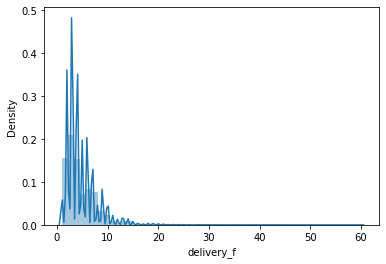

In [240]:
#sns.distplot(df_ps_shop['delivery_f'])

In [241]:
df_ps_del=pd.concat([df_ps_noshop,df_ps_shop])

In [ ]:
#### End: Montly frequency generation 

In [ ]:
#### Aggregation to Households

In [242]:
# Sum individual monthly delivery frequency (group by household ID)
df_ps_del_hh=df_ps_del.groupby(['household_id'])['delivery_f'].sum()
df_ps_del_hh=df_ps_del_hh.to_frame()
df_ps_del_hh.reset_index(level=(0), inplace=True)

In [245]:
# Create household level monthly delivery frequency  
df_hh = pd.read_csv('../Sim_inputs/plans-base-2010/households.csv', header=0, sep=',')

In [247]:
df_hh = df_hh.merge(df_ps_del_hh, on='household_id', how='left')

In [250]:
df_hh.to_csv('../Sim_inputs/households_del.csv', index = False, header=True)

In [ ]:
#### End: Aggregation to Households